# Tutorial: Binary Intrinsic Dimension

## BID summary:

For non interacting random bit streams of length $N$ it is possible to write the exact probability of observing Hamming distance 
$r = |\boldsymbol{\sigma}-\boldsymbol{\sigma}'|_H 
%=\frac{N-\boldsymbol{\sigma} \cdot \boldsymbol{\sigma}}{2}
$ between two i.i.d samples $\boldsymbol{\sigma}$ and $\boldsymbol{\sigma}'$ as 

\begin{equation}
P_0(r) = \frac{1}{2^N} \binom{N}{r}. \tag{1}
\end{equation}

For interacting spins, our model generalizes the previous expression to 

\begin{equation}
P(r)=C\frac{1}{2^{d(r)}}\binom{d(r)}{r}, \tag{2}
\end{equation}
where $C$ is the normalization constant. Eq. 2 reduces to 1
for $ d(r) = N$ and $C=1$. We empirically found that model 2 fits accurately the observed distributions, at least for small distances, if one retains the first two terms of the Taylor expansion:
\begin{equation}
    d(r)=d_0+d_1 \, r \tag{3}
\end{equation}
where $d_0$ and $d_1$ are variational parameters.
In order to infer them
we minimize the Kullbac-Leibler divergence between the empirical probability of Hamming distances $P_{emp}(r)$ and the model $P(r)$ given by Eqs. 2 and 3, 

\begin{equation}
    D_{KL}(P_{emp}||P) = \sum_{r \leq r_{max}} P_{emp}(r) \log{\frac{P_{emp}(r)}{P(r)}}, \tag{4}
\end{equation}
where $r_{max}$ is a meta-parameter that allows constraining the fit to small distance if necessary ( i.e., we discard distances $r>r_{max}$ from $P_{emp}$, we show an example below).
We fix $r_{max}$ by taking it as the quantile of order $\alpha_{max}$ of $P_{emp}$, meaning

\begin{equation}
\alpha_{max} = \sum_{r=0}^{r_{max}} P_{emp}(r), \tag{5}
\end{equation}
where $\alpha_{max} \in [0,1]$. Ideally nothing depends qualitatively on $\alpha_{max}$.


### NOTE: 

In the paper we call $\alpha^* \equiv \alpha_{max}$ and $r^* \equiv r_{max}$.

In practice we also define $\alpha_{min}$ and $r_{min}$ by  

\begin{equation}
\alpha_{min} = \sum_{r=0}^{r_{min}} P_{emp}(r), \tag{6}
\end{equation}
which allow to remove small distances (those with $r<r_{min}$) from $P_{emp}$. These distances sometimes bring problems to the minimization of (4), for example when the histogram is poorly sampled in that regime. 


## Measuring the BID of random bits:


For $N$ random spins the BID coincides with the number of variables. 
The solution for $P(r)$ is exactly Eq. (1) and thus the optimization of (4) must give $d_0=N$ and $d_1=0$.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dadapy.hamming import BID, Hamming
# from aux import BID, Hamming

# REPRODUCIBILITY
seed = 1
np.random.seed(seed=seed)

/home/acevedo/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RANDOM DATA
L = 100  # number of bits
Ns = 5000  # number of samples

# FORMAT NOTE: spins must be normalized to +-1
X = (2 * np.random.randint(low=0, high=2, size=(Ns, L)) - 1) # X.shape=(Ns,L)

In [3]:
# DEFINING COORDINATES
H = Hamming(coordinates=X)

# COMPUTING DISTANCES
H.compute_distances() # stores the matrix of distances between samples in H.distances of shape (Ns,Ns)

# COMPUTING AND SAVING HISTOGRAM OF DISTANCES
histfolder = f'datasets/hamming/random_spins/L{L}/hist/'
filename = f'counts.txt'
H.D_histogram(compute_flag=1,            # if 0 the histograms are loaded instead of computed
              save=True,                 # we compute the histograms once and save time in the future
              resultsfolder=histfolder,  # folder where the histograms are saved
              filename=filename, 
              )

# "H.D_histograms" defines the following attributes. Example:
idx = 5
print(f'{H.D_values[:idx]=}')  # vector containing the sampled distances
print(f'{H.D_counts[:idx]=}')  # vector containing how many times each distance was sampled
print(f'{H.D_probs[:idx]=}')   # same as "D_counts" but normalized by the total number of counts observed 

H.D_values[:idx]=array([25, 26, 27, 28, 29], dtype=int32)
H.D_counts[:idx]=array([  4,   6,  34,  52, 120])
H.D_probs[:idx]=array([3.20e-07, 4.80e-07, 2.72e-06, 4.16e-06, 9.60e-06])


### OPTIMIZATION

(See paper supp. inf for short description about the stochastic optimization performed)

In [4]:
# PARAMETER DEFINITIONS FOR OPTIMIZATION
alphamin = 0        # order of min_quantile, to remove poorly sampled parts of the histogram if necessary (see Supp. Inf. of paper)
alphamax = 1        # order of max_quantile, to define r* (named rmax in the code).
Nsteps = int(1000)   # number of optimization steps
export_results = 1  # flag to export d0,d1,logKL,Pemp,Pmodel after optimization (default=1)
export_logKLs = 1   # flag to export the logKLs during optimization (default=0)
optfolder0 = f"datasets/hamming/random_spins/L{L}/opt/"  # folder where optimization results are saved

steps_initial = np.array([1],dtype=np.double)

B = BID(
    H=H,
    alphamin=alphamin,
    alphamax=alphamax,
    Nsteps=Nsteps,
    steps_initial=steps_initial,
    export_results=export_results,
    export_logKLs=export_logKLs,
    optfolder0=optfolder0,
    L=L, # number of bits in the system
)

B.computeBID()  # results are defined as attributes of B. They are also exported if export_results=1 (default)

print('')
print(f'{B.d0=}')
print(f'{B.d1=}')
print(f'{B.logKL=}')
print(f'{B.rmax=}')

# Note that B.intrinsic_dim is another alias for B.d0
print(f'\n {B.intrinsic_dim=}')

starting optimization
optimization took 1.6 sec
d_0=99.996,d_1=0.000,logKL=-13.009

B.d0=Array(100., dtype=float64)
B.d1=Array(3.1e-05, dtype=float64)
B.logKL=Array(-13.01, dtype=float64)
B.rmax=76

 B.intrinsic_dim=Array(100., dtype=float64)


### explicit model validation: 

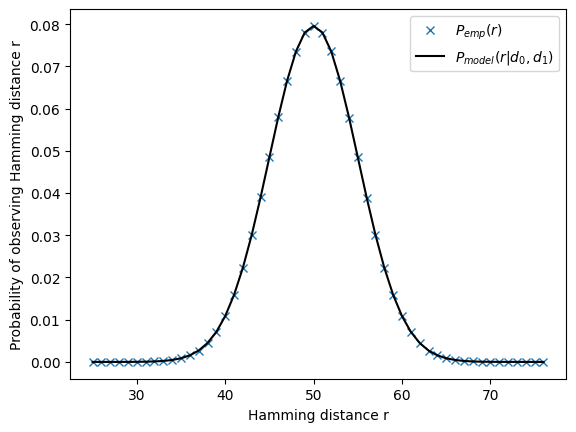

In [5]:
fig,ax = plt.subplots(1)

# empirical distribution of distances
ax.plot(B.remp,
        B.Pemp,
        'x',
        label=r'$P_{emp}(r)$',
        )
# model fit
ax.plot(B.remp,
        B.Pmodel,
        '-',
        color='black',
        label=r'$P_{model}(r|d_0,d_1)$',
        )
plt.ylabel('Probability of observing Hamming distance r')
plt.xlabel('Hamming distance r')
plt.legend()
plt.show()

### KL during optimization

Note that in the original paper, only random moves that minimize (4) are taken, and the rest are discarded. The present implementation does second order gradient descent, calculating numerical derivatives with JAX's autodiff.

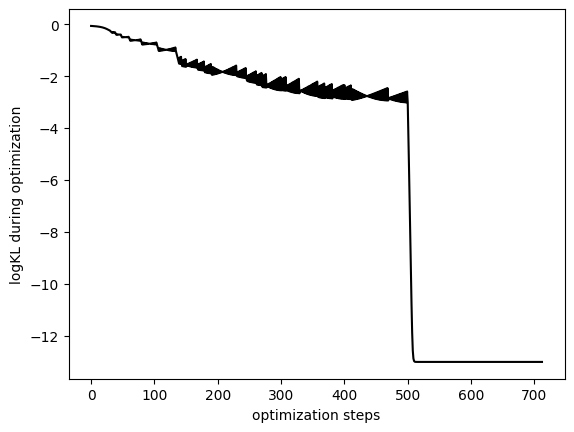

In [6]:
logKLs_opt = B.load_logKLs_opt()
figKL,axKL = plt.subplots()
axKL.plot(logKLs_opt,
          color='black',
          )
plt.ylabel('logKL during optimization')
plt.xlabel('optimization steps')
plt.show()

## 2D Ising model

For this model we showed  in our paper 

- The scaling of the BID with the number of spins
- The temperature dependence of the BID
- The fits of the model (2) to the empirical probabilities of distances for different temperatures

Below we show the full distribution of distances of this model, and what happens to the BID estimation when varying the meta paramater $r_{max}$ defined in (4). 

Some bibliography about the Ising model: 

https://en.wikipedia.org/wiki/Ising_model

https://www.damtp.cam.ac.uk/user/tong/sft/one.pdf

Remember: the exact analytical temperature in the thermodynamic limit (infinite size limit) is $T_c\approx 2.269$.


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dadapy.hamming import BID, Hamming
# from aux import BID, Hamming
eps = 1E-7

### Histograms of distances show the phase transition:

We can see the phase transition in the histogram of all to all (Hamming-)distances, that becomes bimodal due to the presence of two equivalent low-energy states differing only in an global spin flip. In configuration space $\mathcal{C} = \{-1,1\}^N$, for temperature $T < T_c$, we have two clusters: one in which the mayority of spins point upwards and another in which the mayority of spins point downwards. Thus, in the histogram we have inter-cluster small distances and intra-cluster large distances.

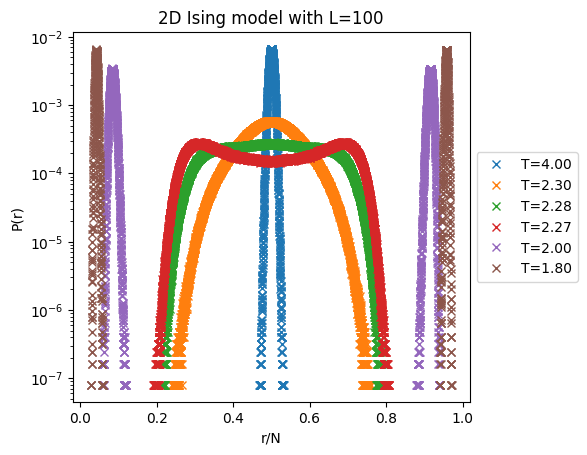

In [8]:
figh,axh = plt.subplots(1)
T_list = np.flip(np.array([1.8,2,2.27,2.28,2.3,4])) # temperature list
L = 100  # system width or height (you can see size-differences putting here L=30)
N = L**2 # total number of spins in a two-dimensional square lattice of length L 
Ns = 5000 # number of samples for each temperature

for T_id,T in enumerate(T_list):
  histfolder = f'datasets/hamming/Ising2D/hist/' # folder where we saved previously computed histograms
  filename = f'L{L}_T{T:.2f}_Ns{Ns}D_counts.txt' # we have different histograms for each L,T and Ns
  H = Hamming()
  H.D_histogram(resultsfolder=histfolder,
                filename=filename,
                ) # this loads H.D_values and H.D_probs
  axh.plot(H.D_values/N,
          H.D_probs,
          'x',
          label=f'{T=:.2f}',
          )

axh.set_yscale('log')
box = axh.get_position()
axh.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axh.legend(loc='center left', bbox_to_anchor=(1, 0.5))

axh.set_xlabel('r/N')
axh.set_ylabel('P(r)')
plt.title(f'2D Ising model with {L=}')
plt.show()

### $r_{max}$ dependence 
We cannot fit a bimodal histogram with our unimodal Ansatz, Eq. (2), so one way to proceed is to make a local fit of the first part of each histogram using the meta-parameter $\alpha_{max}$ defined in Eq. (5). 
Note that any $\alpha_{max} < \frac{1}{2}$  will remove the second part of the histogram. 
Nonetheless $\alpha_{max}$ is not a parameter of the system, so our results should be independent of it. 

Below we show that the BID is approximately independent of the meta-parameter, and moreover this dependency is smaller the larger the system size! 

In [9]:
T_list = np.array([2.,2.3,3]) # list of temperatures
L_list = np.array([30,100])  # list of system-sizes

### OPTIMIZATION PARAMETERS USED FOR THIS EXAMPLE (NEEDED TO LOAD RESULTS)
Nsteps = int(2000)
alphamin_list = [0.0]
alphamax_list = np.arange(.05,0.4+eps,.05) # orders of quantiles of P(r)


### PLACEHOLDERS
d0_list = np.empty(shape=(len(L_list),
                          len(T_list),
                          len(alphamax_list),
                          len(alphamin_list),
                          ),
)
d1_list = np.empty(shape=d0_list.shape)
rmax_list = np.empty(shape=d0_list.shape) # r^* in the paper
logKL_list = np.empty(shape=d0_list.shape)

for L_id,L in enumerate(L_list):
  N = L**2
  for T_id,T in enumerate(T_list):
    for alphamax_id,alphamax in enumerate(alphamax_list):
      for alphamin_id,alphamin in enumerate(alphamin_list):
        optfolder0 = f'datasets/hamming/Ising2D/opt/L{L}/T{T:.2f}/' # folder to put results
        filename = f'L{L}_T{T:.2f}_Ns{Ns}D_counts.txt' # we have different histograms for each L,T and Ns
        H = Hamming()
        H.D_histogram(resultsfolder=histfolder,
                      filename=filename,
                      )
        B = BID(
                H=H,
                alphamin=alphamin,
                alphamax=alphamax,
                Nsteps=Nsteps,
                optfolder0=optfolder0,
                L=N, # number of bits in the system!!
                steps_initial=np.array([1E-1]),
                )
        
        B.computeBID()
        
        (rmax_list[L_id,T_id,alphamax_id,alphamin_id], # r^* in the paper
        d0_list[L_id,T_id,alphamax_id,alphamin_id],    # BID per spin 
        d1_list[L_id,T_id,alphamax_id,alphamin_id],    # the second variational parameter
        logKL_list[L_id,T_id,alphamax_id,alphamin_id], # logarithm of the KL divergence after optimization
        ) = B.load_results()

starting optimization
optimization took 1.5 sec
d_0=61.874,d_1=1.098,logKL=-10.622
starting optimization
optimization took 1.7 sec
d_0=61.333,d_1=1.120,logKL=-10.711
starting optimization
optimization took 1.6 sec
d_0=60.968,d_1=1.132,logKL=-10.508
starting optimization
optimization took 1.6 sec
d_0=60.592,d_1=1.143,logKL=-10.307
starting optimization
optimization took 1.6 sec
d_0=60.226,d_1=1.153,logKL=-10.058
starting optimization
optimization took 1.6 sec
d_0=59.686,d_1=1.166,logKL=-9.512
starting optimization
optimization took 1.7 sec
d_0=59.241,d_1=1.176,logKL=-9.082
starting optimization
optimization took 1.6 sec
d_0=58.635,d_1=1.189,logKL=-8.592
starting optimization
optimization took 1.6 sec
d_0=109.362,d_1=1.516,logKL=-8.880
starting optimization
optimization took 1.6 sec
d_0=106.540,d_1=1.542,logKL=-8.801
starting optimization
optimization took 1.4 sec
d_0=102.935,d_1=1.571,logKL=-7.853
starting optimization
optimization took 1.6 sec
d_0=98.829,d_1=1.601,logKL=-7.054
starting

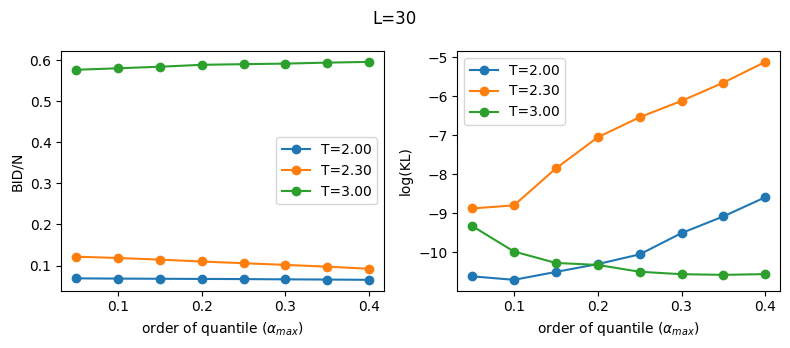

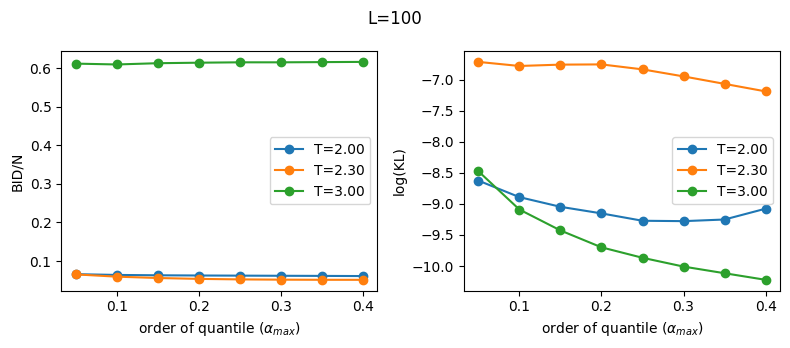

In [10]:
for L_id, L in enumerate(L_list): 
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5))
  ax0, axkl = axs
  for T_id,T in enumerate(T_list):
    lbl = f'{T=:.2f}'
    ax0.plot(alphamax_list,
            d0_list[L_id,T_id,:] / L**2,
            'o-',
            label=lbl,
            )

    axkl.plot(alphamax_list,
            logKL_list[L_id,T_id,:],
            'o-',
            label=lbl,
            )
  ax0.set_ylabel(f"BID/N")
  ax0.set_xlabel(r'order of quantile ($\alpha_{max})$')
  ax0.legend()

  axkl.set_ylabel(f"log(KL)")
  axkl.set_xlabel(r'order of quantile ($\alpha_{max}$)')
  axkl.legend()

  fig.suptitle(f'{L=}')
  plt.tight_layout()
  plt.show()

Note:

* When studying the BID dependence with system parameters (e.g. here temperature or size), we fix the same $\alpha_{max}$ for all calculations. 
$r_{max}$ can be completely different when varying the system parameters, and $\alpha_{max}$ allows to select a $r_{max}$ adaptively and  automatically.

* Close to $T_c$ the small size system ($L=30$) has a higher KL divergence for larger scales ($\alpha_{max}$ close to $\frac{1}{2}$), where the corresponding histogram has a significant superposition of the two peaks that our model cannot fit. Nonetheless the dependence of the BID with $\alpha_{max}$ is very mild. Here any $\alpha_{max}<1/4$ is a safe choice. For $L=100$ we see that any choice of $\alpha_{max}$ is fine (in which case taking the biggest seems natural, since we fit more data).

* If $\alpha_{max}$ is too small (say, less than $0.1$) then we throw away almost all data. We would be fitting the initial part of the histogram than can be noisy or not statistically relevant for the problem. 
For example, In dynamical systems we observe that temporal autocorrelations produce long tails on the left part of the histogram (work in progress), which are physically meaningless.


## Model validation

In continuous black line the model prediction, in colors the empirical probabilities. 

Note that each histogram is cut at some $r_{max}$ depending on the chosen value of $\alpha_{max}$, and re-normalize by the total number of counts in that regime.

You can see what happens with other temperatures like 1.5, 1.6, 1.7, ... ,4 and or L = 30. Just run the optimization!


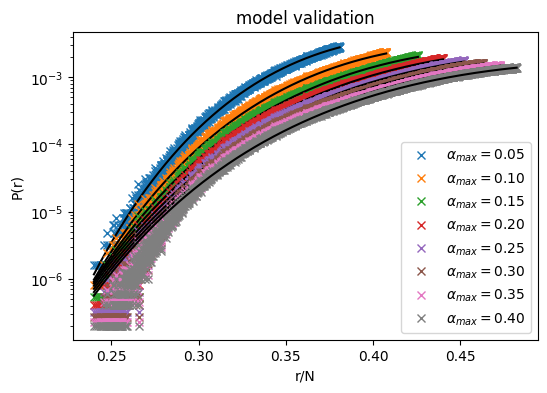

In [11]:
T = 2.3
L = 100
N = L**2

fig,ax = plt.subplots(1,figsize=(6,4))
for alphamax_id,alphamax in enumerate(alphamax_list):
  optfolder0 = f'datasets/hamming/Ising2D/opt/L{L}/T{T:.2f}/' # folder to put results
  B = BID(
          alphamin=alphamin,
          alphamax=alphamax,
          Nsteps=Nsteps,
          optfolder0=optfolder0
          )
  remp,Pemp,Pmodel = B.load_fit()    # to do explicit model validation
  ax.plot(remp/N,Pemp,'x',label=r'$\alpha_{max}=$'+f'{alphamax:.2f}')
  ax.plot(remp/N,Pmodel,'-',color='black')

ax.set_xlabel('r/N')
ax.set_ylabel('P(r)')
plt.title('model validation')
ax.legend()
ax.set_yscale('log')
plt.show()
